<a href="https://colab.research.google.com/github/MNabildawami/deteksiface/blob/main/deteksiface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
!pip install pyheif

EKSTRASI FITUR CIRI GEOMETRI

Best parameters found:  {'hidden_layer_sizes': (128, 64), 'learning_rate_init': 0.001, 'solver': 'adam'}
MLP Model Accuracy: 100.00%

Classification Report:
              precision    recall  f1-score   support

       Fajri       1.00      1.00      1.00         4
       nabil       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



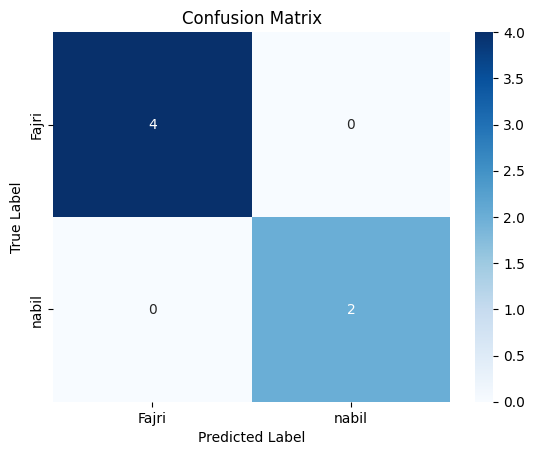

Predicted Name: nabil


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [97]:
import cv2
import dlib
import os
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import pyheif
from PIL import Image
import io
import matplotlib.pyplot as plt
import seaborn as sns

# Download and extract the model file if not already extracted
model_path = "shape_predictor_68_face_landmarks.dat"
if not os.path.exists(model_path):
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

# Load face detector and landmark predictor model
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(model_path)

# =============================== Feature Extraction ===============================

# Function to extract face landmarks data
def extract_face_landmarks_data(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    if len(faces) == 0:
        print("No faces detected.")
        return None

    landmarks_data = []
    for face in faces:
        landmarks = predictor(gray, face)
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            landmarks_data.append((x, y))  # Add (x, y) coordinates to list
    return landmarks_data

# Function to read HEIC images
def read_heic_image(heic_file):
    heif_file = pyheif.read(heic_file)
    image = Image.open(io.BytesIO(heif_file.data))
    return np.array(image)

# Function to process images in folder
def process_folder_images(folder_path):
    data = []
    labels = []

    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} does not exist!")
        return None, None

    # Loop through all subfolders in the main folder
    for folder_name in os.listdir(folder_path):
        folder = os.path.join(folder_path, folder_name)

        if os.path.isdir(folder):
            # Loop through all images in the subfolder
            for file_name in os.listdir(folder):
                file_path = os.path.join(folder, file_name)

                if file_name.lower().endswith(('.jpg', '.jpeg', '.png', '.heic')):  # Filter image files
                    try:
                        if file_name.lower().endswith('.heic'):
                            image = read_heic_image(file_path)
                        else:
                            image = cv2.imread(file_path)

                        if image is None:
                            print(f"Image {file_name} not found or could not be loaded!")
                            continue

                        landmarks_data = extract_face_landmarks_data(image)

                        if landmarks_data is not None:
                            flattened_landmarks = [coord for point in landmarks_data for coord in point]
                            data.append(flattened_landmarks)
                            labels.append(folder_name)  # Use folder_name as the label

                    except Exception as e:
                        print(f"Error processing {file_name}: {e}")
                        continue

    # Create dataframe for the data
    column_names = [f'x{i+1}' for i in range(68)] + [f'y{i+1}' for i in range(68)]
    df = pd.DataFrame(data, columns=column_names)

    # Add the labels as a column in the dataframe
    df['label'] = labels

    # Save the extracted features and labels to CSV and Excel
    df.to_csv('extracted_features.csv', index=False)
    df.to_excel('extracted_features.xlsx', index=False)

    return df, labels

# =============================== Feature Extraction (End) ===============================

# =============================== Classification ===============================

# Define predict_image function
def predict_image(image_path, model, scaler):
    image = cv2.imread(image_path)

    if image is None:
        print(f"Image at {image_path} could not be loaded.")
        return None

    landmarks_data = extract_face_landmarks_data(image)

    if landmarks_data is None:
        print("No face detected in the image!")
        return None

    flattened_landmarks = [coord for point in landmarks_data for coord in point]
    flattened_landmarks = scaler.transform([flattened_landmarks])  # Apply scaling

    predicted_name = model.predict(flattened_landmarks)

    return predicted_name[0]

# Set folder paths for training and testing data
train_folder_path = '/content/drive/MyDrive/footage item pengpol /data_latih'
test_folder_path = '/content/drive/MyDrive/footage item pengpol/data_uji'

# Ensure that the training folder exists
if not os.path.exists(train_folder_path):
    print(f"Training folder '{train_folder_path}' does not exist.")
else:
    # Process all images in the training folder
    landmarks_df, labels = process_folder_images(train_folder_path)

    if landmarks_df is not None:
        # Split dataset into training and testing sets (70% training, 30% testing)
        X_train, X_test, y_train, y_test = train_test_split(landmarks_df.drop(columns=['label']), labels, test_size=0.3, random_state=42)

        # Handle class imbalance using SMOTE
        smote = SMOTE(random_state=42, k_neighbors=1)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        # Scale features
        scaler = StandardScaler()
        X_train_resampled = scaler.fit_transform(X_train_resampled)
        X_test_scaled = scaler.transform(X_test)

        # Train an MLP classifier with grid search for hyperparameter tuning
        mlp_classifier = MLPClassifier(max_iter=500, random_state=42)

        # Set parameter grid for GridSearchCV
        param_grid = {
            'hidden_layer_sizes': [(128, 64), (256, 128)],
            'solver': ['adam', 'sgd'],
            'learning_rate_init': [0.001, 0.01],
        }

        grid_search = GridSearchCV(mlp_classifier, param_grid, cv=3, n_jobs=-1)
        grid_search.fit(X_train_resampled, y_train_resampled)

        print("Best parameters found: ", grid_search.best_params_)

        # Use the best model from GridSearchCV
        best_mlp_classifier = grid_search.best_estimator_

        # Predict labels for test data
        y_pred = best_mlp_classifier.predict(X_test_scaled)

        # Evaluate the classifier
        accuracy = accuracy_score(y_test, y_pred)
        print(f"MLP Model Accuracy: {accuracy * 100:.2f}%")

        # Display classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Display confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(labels))
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.show()

        # Test with an image
        test_image_path = '/content/drive/MyDrive/footage item pengpol /data_uji/Salinan 20241118_222938.jpg'
        predicted_name = predict_image(test_image_path, best_mlp_classifier, scaler)

        if predicted_name:
            print(f"Predicted Name: {predicted_name}")
        else:
            print("No face detected in test image!")

# =============================== Classification (End) ===============================
